# PyG Implementation of LSTM_MGN wiht PEBI data

Install all dependencies using:

`source setup_env.sh`

Now, let's import all of the dependencies that we need for importing and processing data, as well as building, training, and evaluating our model!

In [1]:
import os
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.loader import DataLoader
from torch_geometric_temporal.nn.recurrent import GConvLSTM

import numpy as np
import time
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy
import matplotlib.pyplot as plt


In [2]:
import mesh_model
import stats
from uti_func import ErrorMetrics, count_model_params

# Preparing and Loading the Dataset

Here we show how we processed the dataset to prepare it to work with PyG. We also provided some pre-processed datasets that you can use directly. We first converted these to h5 format to make the data easier to handle with PyTorch and NumPy. This is then processed below.

First, we need to define the root directory and the directories of the datasets, where to save the checkpoint, and where to store animations. The defaults given below will work if you followed the instructions in the first cell above.

In [3]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, 'datasets')
checkpoint_dir = os.path.join(root_dir, 'best_models')
postprocess_dir = os.path.join(root_dir, 'animations')
modelsummary_dir = os.path.join(root_dir, 'model_details')

In [4]:
print("dataset_dir {}".format(dataset_dir))

dataset_dir /data/gpfs/Users/l1072924/04_pebi/datasets


In [5]:
import numpy as np
import torch
import h5py
import functools
import json
from torch_geometric.data import Data
import enum

## Read preprocessed data

The preprocessed data is prepared with another script that translates the direct outputs from GEOSX, field histories and connectivity, to the input and label data. Also, special treatment is needed for the input to be compatible with torch-geometric

In [8]:
file_path=os.path.join(dataset_dir, 'PEBI_Lstm_skip5.pt')
dataset_full_timesteps = torch.load(file_path)
dataset = torch.load(file_path)[:1]

print(dataset)

[Data(x=[1775, 7], edge_index=[2, 10142], edge_attr=[10142, 4], y=[1775, 20], mesh_pos=[1775, 3])]


# Training and Testing

Here we define our training and testing + validation pipelines. Note that these standard given that we defined our MeshGraphNets class to inherit from torch.nn.Module, like a standard PyTorch neural network!

train() iterates through the data for the specified number of epochs, calling the MeshGraphNets class forward functions to get the final decoded node values, and calling the loss function to calculate loss given ground truth data. This is then backpropagated through the network using PyTorch built-in modules to optimize the learned parameters of the MLPs of MeshGraphNets.

For every tenth epoch (to save computation time), the test loss is calculated on the test dataset, and the validation loss is calculated by calculating the velocities from the predicted accelerations of the network. These are added to the returned performance lists. The code below is commented by line for further explanation.

## Train function

In [39]:
def train(dataset, device, stats_list, args, PATH=None):
    '''
    Performs a training loop on the dataset for MeshGraphNets. Also calls
    test and validation functions.
    '''

    df = pd.DataFrame(columns=['epoch','train_loss','test_loss', 'velo_val_loss'])

    #Define the model name for saving 
    model_name= args.model+ '_data_' + args.data_type + '_roll_num_' + str(args.rollout_num) +\
                   '_well_weight_' + str(args.well_weight) +\
                  '_norm'+ str(args.normalized)+ '_model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    args.anim_name = model_name
    #torch_geometric DataLoaders are used for handling the data of lists of graphs
    loader = DataLoader(dataset[:args.train_size], batch_size=args.batch_size, shuffle=False) # each LSTM takes mesh_sizes * timestep
    test_loader = DataLoader(dataset[args.train_size:], batch_size=args.test_batch_size, shuffle=False)

    #The statistics of the data are decomposed
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

    # build model
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    num_classes = 1 # the dynamic variables have the shape of 1 (saturation )

    # Load the pretrained feature extractor
    mgn_model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                        args).to(args.device)
    if (args.pre_trained):
        # load pre-trained model
        assert PATH is not None, "Pre-trained model is not given!"
        mgn_model.load_state_dict(torch.load(PATH, map_location=args.device))
    
    gnn_model_summary(mgn_model, args, 'mgn_pretrained')

    model = TransferTempoMGN( mgn_model, args.hidden_dim, num_classes,
                            args).to(device)

    scheduler, opt = build_optimizer(args, model.parameters())
    #Show the model parameters
    gnn_model_summary(model, args, model_name)

    # train
    losses = []
    test_losses = []
    velo_val_losses = []
    
    best_test_loss = np.inf
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops=0
        cost = 0 
    
        for batch in loader:
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            batch=batch.to(device)
            cost = 0 
            roll_out_loss = 0
            
            for num in range(args.rollout_num):
                if (num == 0):
                    h_0 = torch.zeros(batch.x.shape[0], args.hidden_dim).to(device)
                    c_0 = torch.zeros(batch.x.shape[0], args.hidden_dim).to(device)
                    batch_tmp = copy.deepcopy(batch)
                #print('h_0 {} c_0 {}'.format(h_0.device, c_0.device))
                pred, h_0, c_0 = model(batch_tmp, mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge, h_0, c_0)
                loss = model.loss(pred,batch,mean_vec_y,std_vec_y, num)

                # Now we are learning a mapping between initial condition and the difference between each timestep
                # and initial condition
                batch_tmp.x[:, 0] = unnormalize( pred.squeeze(), mean_vec_y[num], std_vec_y[num] )
                cost = cost + loss # total loss, later being back-propagated
                # Implement a multi-step loss
                roll_out_loss += cost.item()
                num += 1
            
            roll_out_loss /= num
            cost.backward()         #backpropagate loss
            opt.step()
            opt.zero_grad()         #zero gradients each time
            total_loss += roll_out_loss
            num_loops += 1
            del batch_tmp
            del h_0
            del c_0
            
        total_loss /= num_loops
        losses.append(total_loss)

        #Every tenth epoch, calculate acceleration test loss and velocity validation loss
        if epoch % 10 == 0:
            if (args.save_velo_val):
                # save saturation evaluation
                test_loss, velo_val_rmse = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)
                velo_val_losses.append(velo_val_rmse.item())
            else:
                test_loss, _ = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)

            test_losses.append(test_loss.item())

            # saving model
            if not os.path.isdir( args.checkpoint_dir ):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, model_name+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)

        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            if (args.save_velo_val):
              test_losses.append(test_losses[-1])
              velo_val_losses.append(velo_val_losses[-1])

        if (args.save_velo_val):
            df = df.append({'epoch': epoch,'train_loss': losses[-1],
                            'test_loss':test_losses[-1],
                           'velo_val_loss': velo_val_losses[-1]}, ignore_index=True)
        else:
            df = df.append({'epoch': epoch, 'train_loss': losses[-1], 'test_loss': test_losses[-1]}, ignore_index=True)
        if(epoch%100==0):
            if (args.save_velo_val):
                print("train loss", str(round(total_loss, 2)),
                      "test loss", str(round(test_loss.item(), 2)),
                      "velo loss", str(round(velo_val_rmse.item(), 5)))
            else:
                print("train loss", str(round(total_loss,2)), "test loss", str(round(test_loss.item(),2)))

            if(args.save_best_model):
                PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
                torch.save(best_model.state_dict(), PATH )

    return test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader

In [21]:
def test(loader,device,test_model,
         mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y, is_validation,
          delta_t=0.01, save_model_preds=False, model_type=None, loss_weight_list=None):
  
    '''
    Calculates test set losses and validation set errors.
    '''
    loss_test =0
    velo_rmse = 0
    num_loops=0

    for data in loader:
        data=data.to(device)
        with torch.no_grad():
            cost = 0 
            roll_out_loss = 0
            velo_rmse_rollout = 0
            for num in range(args.rollout_num):

                if (num == 0):
                    h_0 = torch.zeros(data.x.shape[0], args.hidden_dim).to(device)
                    c_0 = torch.zeros(data.x.shape[0], args.hidden_dim).to(device)
                    batch_tmp = copy.deepcopy(data)

                pred, h_0, c_0 = test_model(batch_tmp, mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge, h_0, c_0)
                loss = test_model.loss(pred, data, mean_vec_y, std_vec_y, num)
                
                batch_tmp.x[:, 0] = unnormalize( pred.squeeze(), mean_vec_y[num], std_vec_y[num] )
                cost = cost +  loss # total loss, later being back-propagated
                # Implement a multi-step loss
                roll_out_loss += cost

                if (is_validation):
                    #Like for the MeshGraphNets model, calculate the mask over which we calculate
                    #flow loss and add this calculated RMSE value to our val error

                    # pred gives normalized saturation increment
                    eval_velo =  unnormalize( pred.squeeze(), mean_vec_y[num], std_vec_y[num] )
                    gs_velo = data.y[:, num].squeeze()

                    #error = torch.sum((eval_velo - gs_velo) ** 2, axis = -1)
                    error =  (eval_velo - gs_velo)** 2 
                    velo_rmse_rollout += torch.sqrt( torch.mean(error) )
 
                num += 1

            roll_out_loss /= num
            velo_rmse_rollout /= num
            del batch_tmp
            del h_0
            del c_0
            
        loss_test += roll_out_loss
        velo_rmse += velo_rmse_rollout

        num_loops+=1
        # if velocity is evaluated, return velo_rmse as 0
    return loss_test/num_loops, velo_rmse/num_loops

# Let's prepare the model for training!

Specify parameters for model training

## Hyperparameters

In [32]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model': 'Multistep_LSTM_MGN',  
         'data_type': 'PEBI',
         'num_layers': 10,
         'batch_size': 10, 
         'test_batch_size': 4,
         'hidden_dim': 60, 
         'epochs': 2000,
         'opt': 'adam', 
         'rollout_num':20,
         'opt_scheduler': 'none', 
         'opt_restart': 0, 
         'weight_decay': 5e-4, 
         'lr': 0.001,
         'train_size': 180, 
         'test_size': 20, 
         'well_weight': 0.600,
         'device':'cuda',
         'lstm_filter_size':8, 
         'skip': 5, 
         'normalized':True,
         'pre_trained':False, # Import the trained meshgraphnet one-step model as a feature extractor
         'shuffle': True,  # sequence model needs data to be unshuffled
         'save_velo_val': True,
         'anim_name': '',
         'save_best_model': True, 
         'need_edge_weight': False, # if true using edge embeddings for edge weights, otherwise treating edge as unweighted edges 
         'checkpoint_dir': './best_models/',
          'modelsummary_dir': './model_details/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

Load the temporal dataset. Each batch contains all meshes at the same timestep

In [33]:
#dataset = extract_data(torch.load(file_path), [0], args.train_size+args.test_size)
 # train on 5 meshes with 30 timesteps ; test on 1 unseen mesh with 30 timesteps

train_mesh = [i for i in range(args.train_size)]

test_mesh = [i for i in range(args.train_size, 200)]
dataset_train = extract_PEBI_data(torch.load(file_path), train_mesh )
dataset_test = extract_PEBI_data(torch.load(file_path), test_mesh )

dataset = dataset_train + dataset_test 
args.train_size = len(dataset_train)
args.test_size = len(dataset_test)


print( 'Train size {}; Test size {}; total dataset size {}'.format(len(dataset_train), 
                                                                               len(dataset_test),
                                                                               len(dataset)))

print( 'Train batch size {}; Test batch size {}'.format( args.batch_size, 
                                                                               args.test_batch_size))


Train size 180; Test size 20; total dataset size 200
Train batch size 10; Test batch size 4


In [34]:
dataset_test

[Data(x=[1701, 7], edge_index=[2, 9752], edge_attr=[9752, 4], y=[1701, 20], mesh_pos=[1701, 3]),
 Data(x=[1756, 7], edge_index=[2, 10006], edge_attr=[10006, 4], y=[1756, 20], mesh_pos=[1756, 3]),
 Data(x=[1660, 7], edge_index=[2, 9588], edge_attr=[9588, 4], y=[1660, 20], mesh_pos=[1660, 3]),
 Data(x=[1726, 7], edge_index=[2, 9838], edge_attr=[9838, 4], y=[1726, 20], mesh_pos=[1726, 3]),
 Data(x=[1693, 7], edge_index=[2, 9584], edge_attr=[9584, 4], y=[1693, 20], mesh_pos=[1693, 3]),
 Data(x=[1670, 7], edge_index=[2, 9548], edge_attr=[9548, 4], y=[1670, 20], mesh_pos=[1670, 3]),
 Data(x=[1579, 7], edge_index=[2, 9098], edge_attr=[9098, 4], y=[1579, 20], mesh_pos=[1579, 3]),
 Data(x=[1672, 7], edge_index=[2, 9466], edge_attr=[9466, 4], y=[1672, 20], mesh_pos=[1672, 3]),
 Data(x=[1675, 7], edge_index=[2, 9532], edge_attr=[9532, 4], y=[1675, 20], mesh_pos=[1675, 3]),
 Data(x=[1646, 7], edge_index=[2, 9390], edge_attr=[9390, 4], y=[1646, 20], mesh_pos=[1646, 3]),
 Data(x=[1757, 7], edge_inde

Shuffle the dataset and get the statistics of the dataset

In [35]:
if(args.shuffle):
  random.shuffle(dataset)

stats_list = get_stats(dataset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

cuda


In [36]:
stats_list

[tensor([0.0000e+00, 9.8612e-16, 4.2073e-01, 8.8126e-01, 5.9366e-04, 4.8480e-02,
         6.9664e-02]),
 tensor([1.0000e-08, 1.0000e-08, 9.3847e-02, 3.2348e-01, 2.4358e-02, 2.1478e-01,
         2.5458e-01]),
 tensor([  0.0000,   0.0000,   0.0000, 283.9071]),
 tensor([1.6595e+02, 3.3743e+02, 1.0000e-08, 2.4657e+02]),
 tensor([5.9244e-05, 2.8603e-02, 4.3403e-02, 5.6281e-02, 6.4963e-02, 7.3303e-02,
         7.9313e-02, 8.5379e-02, 8.9879e-02, 9.4547e-02, 9.8092e-02, 1.0182e-01,
         1.0473e-01, 1.0782e-01, 1.1025e-01, 1.1287e-01, 1.1494e-01, 1.1723e-01,
         1.1906e-01, 1.2109e-01]),
 tensor([0.0025, 0.0840, 0.1036, 0.1173, 0.1254, 0.1326, 0.1374, 0.1420, 0.1454,
         0.1487, 0.1512, 0.1537, 0.1557, 0.1578, 0.1594, 0.1611, 0.1625, 0.1639,
         0.1651, 0.1664])]

# Training

Start the training!

In [37]:
torch.cuda.empty_cache()

In [38]:
test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader = train(dataset, device, 
                                                                                      stats_list, args)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))
if (args.save_velo_val):
    print("Minimum velocity validation loss: {0}".format(min(velo_val_losses)))

Training:   0%|          | 1/2000 [00:29<16:26:36, 29.61s/Epochs]

train loss 52.51 test loss 49.62 velo loss 0.11889


Training:   5%|▌         | 101/2000 [45:40<17:09:10, 32.52s/Epochs]

train loss 33.96 test loss 39.83 velo loss 0.08968


Training:  10%|█         | 201/2000 [1:32:41<13:32:35, 27.10s/Epochs]

train loss 9.39 test loss 9.52 velo loss 0.05193


Training:  15%|█▌        | 301/2000 [2:17:04<12:48:15, 27.13s/Epochs]

train loss 6.25 test loss 9.49 velo loss 0.05112


Training:  20%|██        | 401/2000 [3:01:24<12:03:05, 27.13s/Epochs]

train loss 4.54 test loss 9.18 velo loss 0.0503


Training:  25%|██▌       | 501/2000 [3:45:46<11:16:15, 27.07s/Epochs]

train loss 4.59 test loss 9.85 velo loss 0.05052


Training:  30%|███       | 601/2000 [4:30:05<10:30:18, 27.03s/Epochs]

train loss 3.41 test loss 8.64 velo loss 0.04806


Training:  35%|███▌      | 701/2000 [5:14:26<9:48:55, 27.20s/Epochs] 

train loss 3.12 test loss 8.87 velo loss 0.04741


Training:  40%|████      | 801/2000 [5:58:48<9:02:03, 27.13s/Epochs]

train loss 3.28 test loss 9.76 velo loss 0.04952


Training:  45%|████▌     | 901/2000 [6:43:09<8:16:23, 27.10s/Epochs]

train loss 2.94 test loss 8.84 velo loss 0.04814


Training:  50%|█████     | 1001/2000 [7:27:29<7:31:04, 27.09s/Epochs]

train loss 2.3 test loss 8.93 velo loss 0.04672


Training:  55%|█████▌    | 1101/2000 [8:11:50<6:46:20, 27.12s/Epochs]

train loss 1.92 test loss 9.04 velo loss 0.04752


Training:  60%|██████    | 1201/2000 [8:56:10<6:01:22, 27.14s/Epochs]

train loss 1.61 test loss 9.46 velo loss 0.04739


Training:  65%|██████▌   | 1301/2000 [9:40:48<5:18:39, 27.35s/Epochs]

train loss 1.91 test loss 8.91 velo loss 0.04786


Training:  70%|███████   | 1401/2000 [10:25:09<4:30:24, 27.09s/Epochs]

train loss 1.5 test loss 9.14 velo loss 0.04745


Training:  75%|███████▌  | 1501/2000 [11:09:30<3:44:44, 27.02s/Epochs]

train loss 1.68 test loss 8.98 velo loss 0.04591


Training:  80%|████████  | 1601/2000 [11:53:49<2:59:55, 27.06s/Epochs]

train loss 1.65 test loss 9.21 velo loss 0.04825


Training:  85%|████████▌ | 1701/2000 [12:38:08<2:14:51, 27.06s/Epochs]

train loss 1.38 test loss 8.87 velo loss 0.04656


Training:  90%|█████████ | 1801/2000 [13:22:27<1:29:57, 27.12s/Epochs]

train loss 1.52 test loss 9.02 velo loss 0.04711


Training:  95%|█████████▌| 1901/2000 [14:06:48<44:42, 27.09s/Epochs]  

train loss 1.52 test loss 8.9 velo loss 0.04687


Training: 100%|██████████| 2000/2000 [14:50:41<00:00, 26.72s/Epochs]

Min test set loss: 8.575910568237305
Minimum loss: 1.1801764013866582
Minimum velocity validation loss: 0.04585757479071617


Let's visualize the results!

In [40]:
def save_plots(args, losses, test_losses, velo_val_losses):
    
    #Define the model name for saving 
    model_name= args.model + '_data_'+ args.data_type + '_LSTM_k_' + str(args.lstm_filter_size )+ '_well_weight_' + str(args.well_weight) +\
                  '_norm'+ str(args.normalized)+ '_model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)
    
    if not os.path.isdir(args.postprocess_dir):
        os.mkdir(args.postprocess_dir)

    PATH = os.path.join(args.postprocess_dir, model_name + '.pdf')

    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses, label="training loss" + " - " + args.model)
    plt.plot(test_losses, label="test loss" + " - " + args.model)
    #if (args.save_velo_val):
    #    plt.plot(velo_val_losses, label="velocity loss" + " - " + args.model_type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    f.savefig(PATH, bbox_inches='tight')

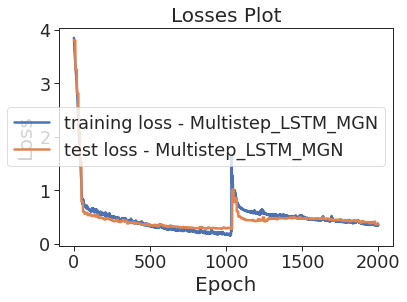

In [41]:
save_plots(args, losses, test_losses, velo_val_losses)